<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transfer learning with tensorflow part 3: scaling up (food vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-11-03 20:40:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-03 20:40:24 (140 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, unzip_data

## 101 food classes: working with less data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-11-03 20:40:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   128MB/s    in 13s     

2025-11-03 20:40:47 (123 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 i

In [ ]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* create a ModelChecpoint callback
* create a data augmentation layer to build data augmentation right in the model
* build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model
* feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [ ]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmentation")

In [ ]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weigts which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Get the summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - accuracy: 0.1573 - loss: 3.9528 - val_accuracy: 0.4693 - val_loss: 2.5261
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.4785 - loss: 2.3185 - val_accuracy: 0.4958 - val_loss: 2.1075
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.5504 - loss: 1.8955 - val_accuracy: 0.5260 - val_loss: 1.8988
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5908 - loss: 1.6851 - val_accuracy: 0.5302 - val_loss: 1.8351
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.6196 - loss: 1.5223 - val_accuracy: 0.5418 - val_loss: 1.7588


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5585 - loss: 1.6809


[1.5969831943511963, 0.5790098905563354]

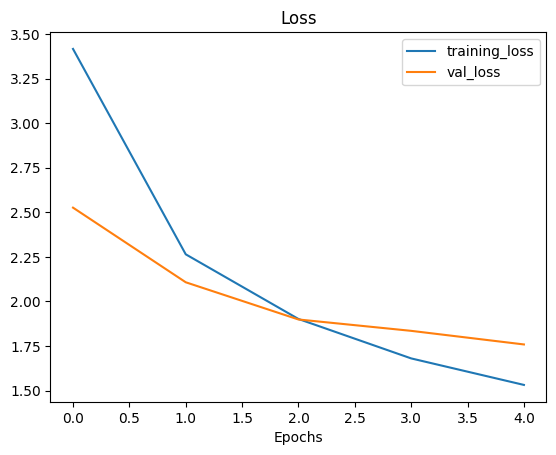

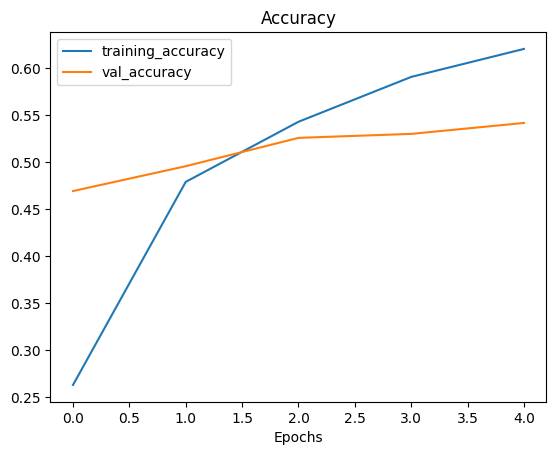

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning_rate reduced by 10x
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.6355 - loss: 1.4863 - val_accuracy: 0.5604 - val_loss: 1.7055
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.6823 - loss: 1.3108 - val_accuracy: 0.5747 - val_loss: 1.6587
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.6960 - loss: 1.2302 - val_accuracy: 0.5734 - val_loss: 1.6404
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.7095 - loss: 1.1600 - val_accuracy: 0.5787 - val_loss: 1.6057
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.7275 - loss: 1.1021 - val_accuracy: 0.5845 - val_loss: 1.5805
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7354 - loss: 1.0578 - val_accuracy: 0.5863 - val_loss: 1.5791


In [ ]:
# Evaluate the whole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5990 - loss: 1.5074


[1.4158804416656494, 0.6205544471740723]

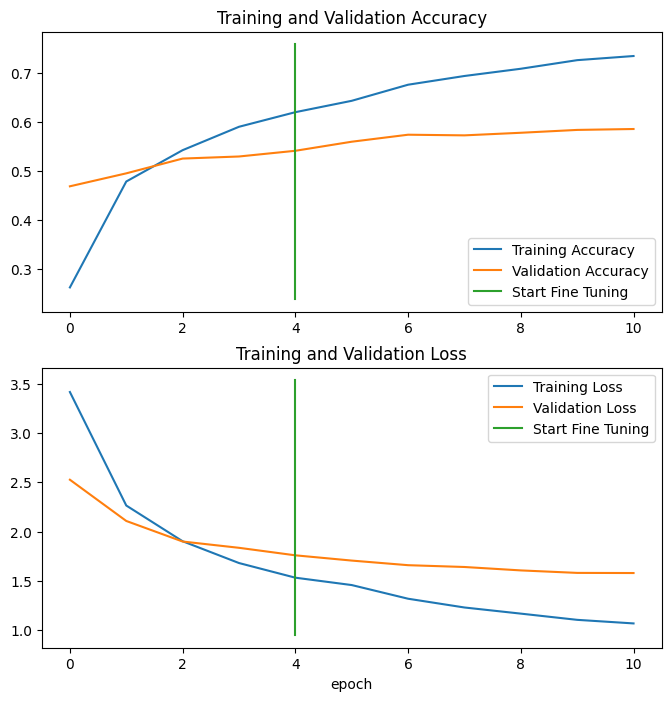

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.5990 - loss: 1.5074


[1.4158804416656494, 0.6205544471740723]

In [ ]:
# The results from ourloaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4158804416656494, 0.6205544471740723]

## Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong

In [ ]:
import tensorflow as tf

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip

In [ ]:
unzip_data('/content/drive/MyDrive/tensorflow_course/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
!ls -R /content/06_101_food_class_10_percent_saved_big_dog_model/

/content/06_101_food_class_10_percent_saved_big_dog_model/:
assets	saved_model.pb	variables

/content/06_101_food_class_10_percent_saved_big_dog_model/assets:

/content/06_101_food_class_10_percent_saved_big_dog_model/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
import tensorflow as tf

# Load in saved model using tf.saved_model.load
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')


ValueError: File format not supported: filepath=/content/06_101_food_class_10_percent_saved_big_dog_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/06_101_food_class_10_percent_saved_big_dog_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
# Evaluate the loaded Keras Model on test data
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.5990 - loss: 1.5074


[1.4158804416656494, 0.6205544471740723]

## Make predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[2.5638062e-01, 5.6808745e-04, 2.4200261e-01, ..., 4.5002893e-05,
        5.2854712e-03, 2.1026380e-02],
       [8.8202107e-01, 2.0242418e-07, 1.6287400e-03, ..., 2.7552014e-03,
        1.2274000e-06, 2.1913109e-05],
       [3.1100601e-01, 1.1819804e-02, 2.2435138e-02, ..., 1.5637773e-03,
        6.0918648e-04, 1.5607210e-03],
       ...,
       [2.8123599e-01, 1.4939378e-05, 2.1129088e-03, ..., 3.5467546e-02,
        3.2479636e-04, 3.9970360e-04],
       [2.1968469e-01, 5.5183063e-04, 1.8954745e-01, ..., 6.3552510e-04,
        8.7931301e-05, 4.2529622e-04],
       [5.7789183e-01, 6.3635025e-06, 4.2926827e-03, ..., 1.6652650e-03,
        8.6226373e-06, 9.1999047e-04]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.5638062e-01, 5.6808745e-04, 2.4200261e-01, 7.3062159e-07,
        2.7063465e-05, 5.0000399e-06, 5.4773031e-04, 3.2789510e-05,
        7.0426188e-02, 1.7291776e-04, 1.2825945e-05, 6.1356545e-06,
        1.1293599e-03, 2.2958402e-06, 9.7288322e-03, 1.5397917e-03,
        1.4930830e-04, 3.6871480e-03, 8.2024932e-03, 2.0756534e-05,
        1.1107767e-03, 4.3567532e-05, 8.5445610e-04, 3.8856512e-04,
        5.5572024e-04, 2.2216064e-03, 8.1607688e-04, 2.1311601e-04,
        2.3948573e-02, 2.8579799e-03, 5.4055222e-06, 2.1835091e-03,
        6.7094219e-04, 2.2334209e-05, 3.9094775e-03, 8.4995645e-06,
        3.5585405e-04, 4.5942827e-03, 2.4370302e-02, 3.4505985e-04,
        9.9076540e-04, 1.3695682e-03, 1.1021178e-03, 6.5530228e-05,
        2.3338656e-04, 8.7565910e-05, 1.4684222e-03, 1.3808424e-04,
        1.9891202e-05, 2.9235732e-02, 5.9443607e-04, 7.6144825e-05,
        7.8753032e-02, 3.2341763e-02, 8.9914669e-05, 7.8828782e-03,
        1.3393740e-02, 1.4547422e-03, 6.2525230e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [2.5638062e-01 5.6808745e-04 2.4200261e-01 7.3062159e-07 2.7063465e-05
 5.0000399e-06 5.4773031e-04 3.2789510e-05 7.0426188e-02 1.7291776e-04
 1.2825945e-05 6.1356545e-06 1.1293599e-03 2.2958402e-06 9.7288322e-03
 1.5397917e-03 1.4930830e-04 3.6871480e-03 8.2024932e-03 2.0756534e-05
 1.1107767e-03 4.3567532e-05 8.5445610e-04 3.8856512e-04 5.5572024e-04
 2.2216064e-03 8.1607688e-04 2.1311601e-04 2.3948573e-02 2.8579799e-03
 5.4055222e-06 2.1835091e-03 6.7094219e-04 2.2334209e-05 3.9094775e-03
 8.4995645e-06 3.5585405e-04 4.5942827e-03 2.4370302e-02 3.4505985e-04
 9.9076540e-04 1.3695682e-03 1.1021178e-03 6.5530228e-05 2.3338656e-04
 8.7565910e-05 1.4684222e-03 1.3808424e-04 1.9891202e-05 2.9235732e-02
 5.9443607e-04 7.6144825e-05 7.8753032e-02 3.2341763e-02 8.9914669e-05
 7.8828782e-03 1.3393740e-02 1.4547422e-03 6.2525230e-03 6.0867656e-05
 5.8537389e-06 3.9584497e-03 1.1552895e-02 9.2

In [ ]:
test_data.class_names[0]

'apple_pie'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29,  0,  9,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

 Now we've got a prediction array of all our model's predictions. to evaluate them, we need to compare them to the labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] #look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [ ]:
len(y_labels)

25250